# 数据读取 

In [ ]:
import torch
from torch_geometric.data import Data
import os
import sys
# ===== 手动指定 .pt 文件路径 =====
pt_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/mixed_allclass/pyg_data/time/mixed_allclass_arabic_graph_withmask.pt"

# ===== 检查文件是否存在 =====
if not os.path.exists(pt_path):
    raise FileNotFoundError(f"❌ 文件未找到: {pt_path}")

# ===== 加载 pt 文件 =====
loaded_obj = torch.load(pt_path, map_location="cpu")

# ===== 判断文件类型并恢复 Data 对象 =====
if isinstance(loaded_obj, Data):
    data = loaded_obj
    print(f"✅ 成功加载 PyG Data 对象: {pt_path}")
elif isinstance(loaded_obj, dict):
    data = Data(**loaded_obj)
    print(f"✅ 从字典重建 PyG Data 对象: {pt_path}")
else:
    raise TypeError(f"⚠️ 不支持的文件内容类型: {type(loaded_obj)}")

# ===== 打印数据信息 =====
print("📊 ===== Data 概要 =====")
print(f"节点特征数 x.shape: {tuple(data.x.shape) if data.x is not None else None}")
print(f"边数量 edge_index.shape: {tuple(data.edge_index.shape) if data.edge_index is not None else None}")
print(f"标签 y.shape: {tuple(data.y.shape) if data.y is not None else None}")
print(f"是否包含 train/val/test mask: {[hasattr(data, k) for k in ['train_mask', 'val_mask', 'test_mask']]}")
print("========================\n")

# ===== 访问内容示例 =====
print(data)
print("前5个节点特征：")
print(data.x[:5])
print("前10条边索引：")
print(data.edge_index[:, :10])



# 模型初始化

In [ ]:
import torch
from torch import optim
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid

# ==============================
# 定义超参数
# ==============================
in_channels = data.num_node_features    # 输入维度（根据数据集自动确定）
hidden_dim = 256                        # GCN隐藏层维度
projection_dim = 128                    # 投影头输出维度
prediction_dim = 128                    # 预测头输出维度
num_layers = 2                          # GCN层数
learning_rate = 1e-3                    # 学习率
momentum = 0.99                         # 动量更新系数

# ==============================
# 初始化模型与优化器
# ==============================
import sys
sys.path.append("../src")
from models import BGRL, GCNEncoder, cosine_loss  

# 构造encoder
encoder = GCNEncoder(
    in_channels=in_channels,
    hidden_channels=hidden_dim,
    num_layers=num_layers,
)

# 构造BGRL主体
model = BGRL(
    encoder=encoder,
    hidden_dim=hidden_dim,
    projection_dim=projection_dim,
    prediction_dim=prediction_dim,
)

# 自动选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data_pyg = data.to(device)

# 优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ==============================
# 训练前检查
# ==============================
print("🚀 Model initialized successfully!")
print(f"Device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 训练

In [ ]:
import torch
import torch.nn.functional as F
import sys
import os
sys.path.append("../src")
from models import augment_graph

num_epochs = 200
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_BGRL/model_save/time"  # ← 替换成你的保存路径

# ===================== 自监督预训练 =====================
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    # ---- 图增强：两种视图 ----
    graph1 = augment_graph(data)
    graph2 = augment_graph(data)
    graph1, graph2 = graph1.to(device), graph2.to(device)

    x1, edge_index1 = graph1.x, graph1.edge_index
    x2, edge_index2 = graph2.x, graph2.edge_index

    # ---- Online 分支 ----
    _, p1 = model.forward_online(x1, edge_index1)
    _, p2 = model.forward_online(x2, edge_index2)

    # ---- Target 分支 (无梯度更新) ----
    with torch.no_grad():
        z1 = model.forward_target(x1, edge_index1)
        z2 = model.forward_target(x2, edge_index2)

    # ---- BGRL 损失函数 ----
    loss = cosine_loss(p1, z2) / 2 + cosine_loss(p2, z1) / 2

    # ---- 反向传播与更新 ----
    loss.backward()
    optimizer.step()

    # ---- EMA 更新目标网络参数 ----
    model.update_momentum(momentum)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

print("\n✅ 自监督预训练完成。")

# ===================== 保存模型 =====================
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"BGRL_epoch{num_epochs}.pt")

# 建议保存整个模型结构（方便后续直接加载）
torch.save({
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, model_path)

print(f"💾 模型已保存到：{model_path}")

✅ Using device: cuda
🎯 模型结构加载完成: 输入维度 5, 隐藏维度 256, 层数 2
📊 图数据加载完成: 节点数 12500, 特征维度 5


/tmp/ipykernel_2976518/3750892806.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
/tmp/ipykernel_2976518/375089

🧩 嵌入维度: (2500, 256)
🚀 正在执行 UMAP 降维...


/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP 完成.
📈 Silhouette Score（聚类质量指标）: -0.0690


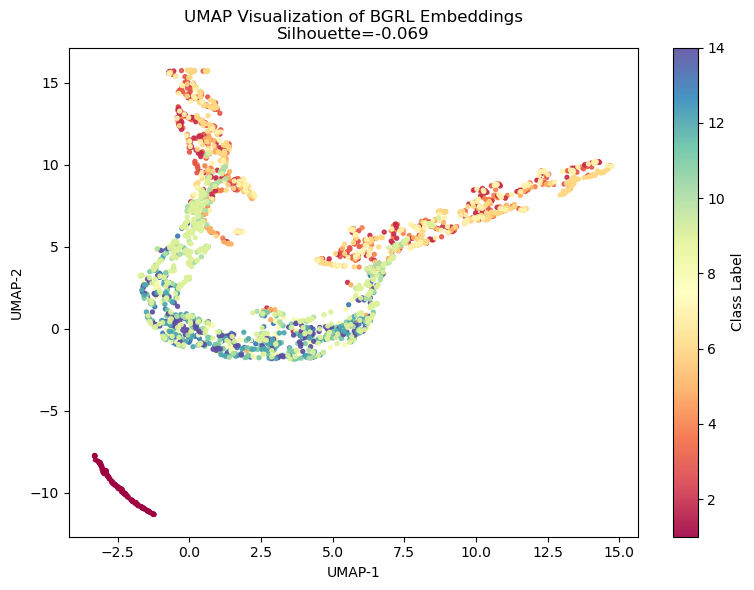

💾 可视化图像已保存至: /home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_BGRL/result/time/BGRL_UMAP_visualization.png
💾 嵌入结果已保存到: /home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_BGRL/result/time/BGRL_UMAP_embeddings.csv


In [2]:
# ============================================================
#  📘 KAIST_BGRL 模型嵌入可视化 (UMAP)
# ============================================================

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.metrics import silhouette_score
from torch_geometric.data import Data

# ========== 1️⃣ 路径与设备 ==========
graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/mixed_allclass/pyg_data/time/mixed_allclass_arabic_graph_withmask.pt"
model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_BGRL/model_save/time/BGRL_epoch200.pt"
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_BGRL/result/time"

os.makedirs(save_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Using device: {device}")

# ========== 2️⃣ 加载模型 ==========
import sys
sys.path.append("../src")
from models import BGRL, GCNEncoder  # 使用你提供的定义

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint

# 自动推断维度
conv_weights = [v for k, v in state_dict.items() if "online_encoder.convs" in k and "weight" in k]
in_channels = conv_weights[0].shape[1]
hidden_channels = conv_weights[-1].shape[0]
num_layers = len(conv_weights)

# 你在 BGRL 中需要传入 encoder 实例 + 三个维度参数
projection_dim = hidden_channels  //2    # 通常 projection 与 hidden 一致
prediction_dim = hidden_channels // 2 # 可稍小，例如 hidden_dim/2

encoder = GCNEncoder(in_channels, hidden_channels, num_layers=num_layers)
model = BGRL(
    encoder=encoder,
    hidden_dim=hidden_channels,
    projection_dim=projection_dim,
    prediction_dim=prediction_dim,
).to(device)

model.load_state_dict(state_dict, strict=False)
model.eval()

print(f"🎯 模型结构加载完成: 输入维度 {in_channels}, 隐藏维度 {hidden_channels}, 层数 {num_layers}")


# ========== 3️⃣ 加载图数据 ==========
data: Data = torch.load(graph_path, map_location=device)
data = data.to(device)
print(f"📊 图数据加载完成: 节点数 {data.num_nodes}, 特征维度 {data.x.size(-1)}")

# ========== 4️⃣ 提取嵌入 ==========
with torch.no_grad():
    z = model.online_encoder(data.x, data.edge_index)
z = z.cpu().numpy()

# 使用 test_mask
mask = data.test_mask.cpu().numpy()
if hasattr(data, "y") and data.y is not None:
    labels = data.y.cpu().numpy()[mask]
else:
    labels = np.zeros(mask.sum(), dtype=int)
    print("⚠️ 未检测到 data.y，使用占位标签。")

embeddings = z[mask]
print(f"🧩 嵌入维度: {embeddings.shape}")

# ========== 5️⃣ UMAP 降维 ==========
print("🚀 正在执行 UMAP 降维...")
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)
z_umap = umap_model.fit_transform(embeddings)
print("✅ UMAP 完成.")

# ========== 6️⃣ 性能指标 ==========
silhouette = silhouette_score(z_umap, labels) if len(np.unique(labels)) > 1 else np.nan
print(f"📈 Silhouette Score（聚类质量指标）: {silhouette:.4f}")

# ========== 7️⃣ 可视化 ==========
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_umap[:, 0], z_umap[:, 1], c=labels, cmap="Spectral", s=8, alpha=0.9)
plt.colorbar(scatter, label="Class Label")
plt.title(f"UMAP Visualization of BGRL Embeddings\nSilhouette={silhouette:.3f}")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

plot_path = os.path.join(save_dir, "BGRL_UMAP_visualization.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"💾 可视化图像已保存至: {plot_path}")

# ========== 8️⃣ 保存嵌入结果 ==========
import pandas as pd

emb_df = pd.DataFrame(z_umap, columns=["UMAP_1", "UMAP_2"])
emb_df["label"] = labels
csv_path = os.path.join(save_dir, "BGRL_UMAP_embeddings.csv")
emb_df.to_csv(csv_path, index=False)

print(f"💾 嵌入结果已保存到: {csv_path}")
